In [82]:
# Librerias necesarias
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from datetime import datetime

from skimage import exposure
from PIL import Image
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt


## ETAPA DE PREPROCESAMIENTO

In [83]:
image_path = "Imagenes_convertidas/Right/1-1-9.png"

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)


## Cargar imagen


In [84]:
def read_imageResize_with_labels(dir='..\database\dataset',target_size = (224,224)):
    """
    Lee imágenes de un directorio, las redimensiona a 224x224 píxeles y las etiqueta según 
    la subcarpeta en la que se encuentran. Las imágenes son procesadas en escala de grises.

    Parámetros:
    dir (str): La ruta del directorio principal que contiene las subcarpetas con las imágenes. 
               Las subcarpetas deben llamarse 'normal', 'benigno' y 'maligno' para que 
               las etiquetas se asignen correctamente. Las subcarpetas no definidas 
               recibirán una etiqueta de -1.

    Retorno:
    tuple: Una tupla que contiene dos elementos:
        - np.array: Un array de NumPy con las imágenes redimensionadas.
        - list: Una lista de etiquetas correspondientes a las imágenes.
    """
    labels = []
    imgs = []
    for subfolder in os.listdir(dir):
        
        subfolder_path = os.path.join(dir,subfolder)
        for name_image in os.listdir(subfolder_path):
            bandera = False    

            # Obtener la etiqueta desde el nombre de la subcarpeta
            if subfolder == 'normal':
                bandera = True
                labels.append(0)
            elif subfolder == 'benigno':
                bandera = True
                labels.append(1)
            elif subfolder == 'maligno':
                bandera = True
                labels.append(2)

            if bandera:    
           
                # Obtenemos la ruta de la imagen
                image_path = os.path.join(subfolder_path,name_image)
                
                # Read the image using TensorFlow for GPU acceleration
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Resize the image
                image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
            
                imgs.append(image)
    
    return  np.array(imgs), labels

## Histograma y umbralización

In [85]:
def img_compar(img_original, img_preprocess):
    '''
    Funcion utilizada para comparar la imagen antes y despues del procesmiento
    
    Parametros: 
    - img_original: imagen antes del procesamiento
    - img_preprocess: imagen procesada
    
    Output: La funcion muestra una figura de matplotlib con la imagen original y procesada
    '''

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(img_preprocess, cmap='gray')
    plt.title('Imagen Preprocesada')
    plt.axis('on')

    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

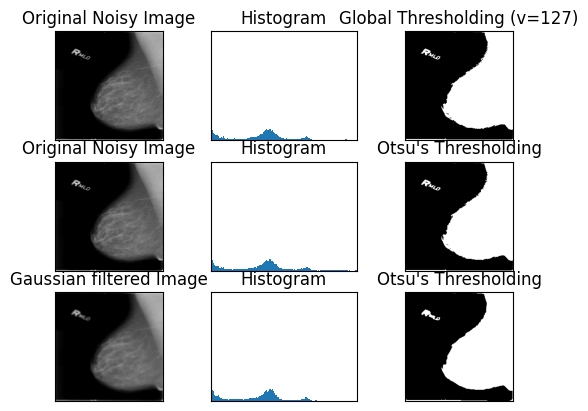

In [86]:
# global thresholding
ret1,th1 = cv2.threshold(img,60,255,cv2.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding y  Gaussian filter
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

images = [img, 0, th1,
 img, 0, th2,
 blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
 'Original Noisy Image','Histogram',"Otsu's Thresholding",
 'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3, 3, i*3+1), plt.imshow(images[i*3], 'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3, 3, i*3+2), plt.hist(images[i*3].ravel(), bins=256, range=[0, 256])
    plt.title(titles[i*3+1]), plt.xlim([0, 256]), plt.ylim([0, 5000]), plt.xticks([]), plt.yticks([])
    plt.subplot(3, 3, i*3+3), plt.imshow(images[i*3+2], 'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show

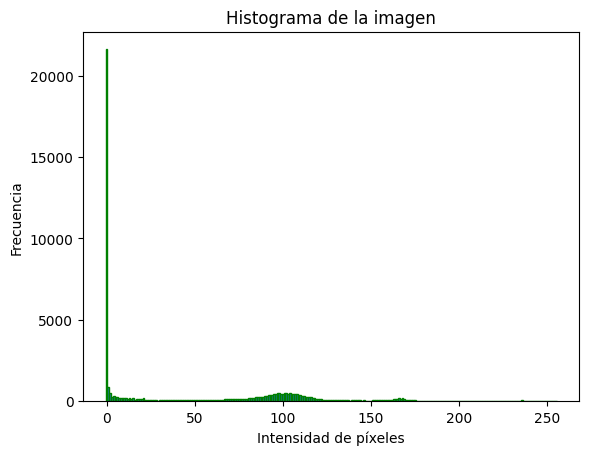

In [87]:
def mostrar_histograma(img):
    """
    Muestra el histograma de una imagen en escala de grises.

    Parámetros:
    ----------
    img : numpy.ndarray
        Imagen en formato de matriz de NumPy, generalmente en escala de grises. 
        Si la imagen tiene múltiples canales (como una imagen a color), se 
        utilizará solo el primer canal (canal de intensidad).

    """

    hist = cv2.calcHist([img], [0], None, [256], [0, 256])


    plt.bar(np.arange(256), hist[:, 0], width=1.0, edgecolor='green')
    plt.title('Histograma de la imagen')
    plt.xlabel('Intensidad de píxeles')
    plt.ylabel('Frecuencia')
    plt.show()


mostrar_histograma(img)

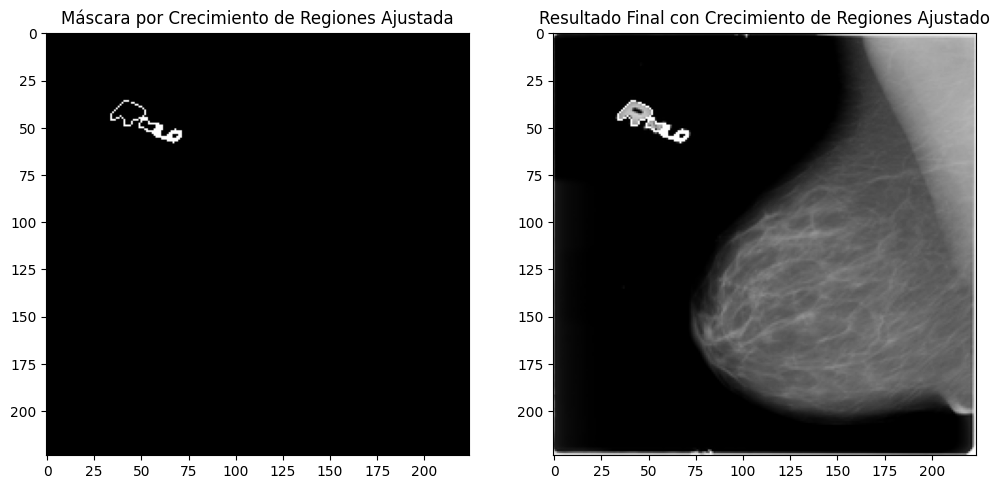

In [88]:

from skimage.segmentation import flood
img_blur = cv2.GaussianBlur(img, (5, 5), 0)

   
seed_point = (50, 50)  

  
flood_mask = flood(img_blur, seed_point, tolerance=25)


result_flood_fill = img.copy()
result_flood_fill[flood_mask] = 255  


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(flood_mask, cmap='gray')
ax[0].set_title("Máscara por Crecimiento de Regiones Ajustada")
ax[1].imshow(result_flood_fill, cmap='gray')
ax[1].set_title("Resultado Final con Crecimiento de Regiones Ajustado")
plt.show()

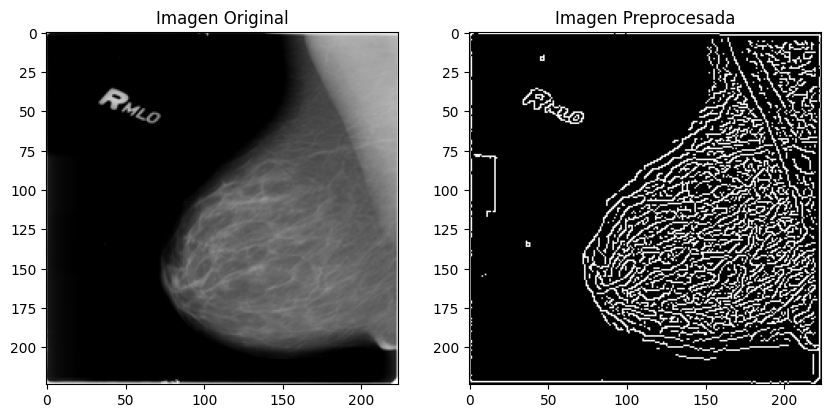

In [89]:
def filter_canny(img):
    """
    Aplica el filtro de detección de bordes de Canny a una imagen.

    Parámetros:
    -----------
    img : numpy.ndarray
        Imagen de entrada en formato de matriz de NumPy. Puede ser una imagen en escala de grises
        o en color (en cuyo caso, OpenCV la convertirá a escala de grises internamente).
    """
    t_lower = 50 
    t_upper = 150 ¿
    aperture_size = 5  
     
    edge = cv2.Canny(img, t_lower, t_upper,  
                    apertureSize=aperture_size) 
    return edge
canny_img = filter_canny(img)
img_compar(img,canny_img)


## Método 2

In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing_with_adaptive_gradient(img, seed_point, intensity_threshold=20, gradient_threshold=30):
    """
    Realiza el crecimiento de regiones controlado por gradientes adaptativos.

    Parámetros:
    - img: Imagen en escala de grises.
    - seed_point: Tupla (x, y) con la posición de la semilla.
    - intensity_threshold: Umbral de similitud de intensidad.
    - gradient_threshold: Umbral inicial para el gradiente.

    Retorna:
    - mask: Máscara binaria de la región crecida.
    """

    rows, cols = img.shape
    x , y = seed_point


    if (img[seed_point] < 30):
        x = rows -  x

    seed_point = (x,y)
    print("valor semilla: ",seed_point)

    mask = np.zeros((rows, cols), np.uint8)
    visited = np.zeros((rows, cols), bool)

    # Calcular gradiente para detección de bordes
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)
    gradient_magnitude = np.uint8(gradient_magnitude)

    cv2.normalize(gradient_magnitude, gradient_magnitude, 0, 255, cv2.NORM_MINMAX)

    seed_value = img[seed_point[1], seed_point[0]]
    region_mean = float(seed_value)
    region_size = 1

    stack = [seed_point]

    while stack:
        x, y = stack.pop()
        if visited[y, x]:
            continue
        visited[y, x] = True
        mask[y, x] = 255

        # Actualizar estadísticas de la región
        current_value = img[y, x]
        region_mean = (region_mean * region_size + current_value) / (region_size + 1)
        region_size += 1

        # Vecinos en 8 direcciones
        for dx, dy in [(-1, -1), (0, -1), (1, -1),
                       (-1,  0),         (1,  0),
                       (-1,  1), (0,  1), (1,  1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < cols and 0 <= ny < rows and not visited[ny, nx]:
                neighbor_value = img[ny, nx]
                intensity_diff = abs(int(neighbor_value) - int(region_mean))
                gradient_value = gradient_magnitude[ny, nx]

                # Calcular umbral adaptativo para el gradiente
                local_gradient_threshold = gradient_threshold * (1 + intensity_diff / 255)

                if (intensity_diff <= intensity_threshold and
                    gradient_value <= local_gradient_threshold):
                    stack.append((nx, ny))

    return mask,gradient_magnitude



In [91]:
img_blur = cv2.GaussianBlur(img, (5, 5), 0)


seed_point=(10,10)

mask,gradient_magnitude= region_growing_with_adaptive_gradient(
    img_blur,
    seed_point,
    intensity_threshold=20,
    gradient_threshold=30
)


kernel = np.ones((5,5), np.uint8)
mask_morph = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)


contours, _ = cv2.findContours(mask_morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
hull = [cv2.convexHull(contour) for contour in contours]
mask_hull_f2 = np.zeros_like(mask_morph)
cv2.drawContours(mask_hull_f2, hull, -1, 255, thickness=cv2.FILLED)


mask_dilated = cv2.dilate(mask_hull_f2, kernel, iterations=1)

mask_inv = cv2.bitwise_not(mask_dilated)
result = cv2.bitwise_and(img, img, mask=mask_inv)



valor semilla:  (214, 10)


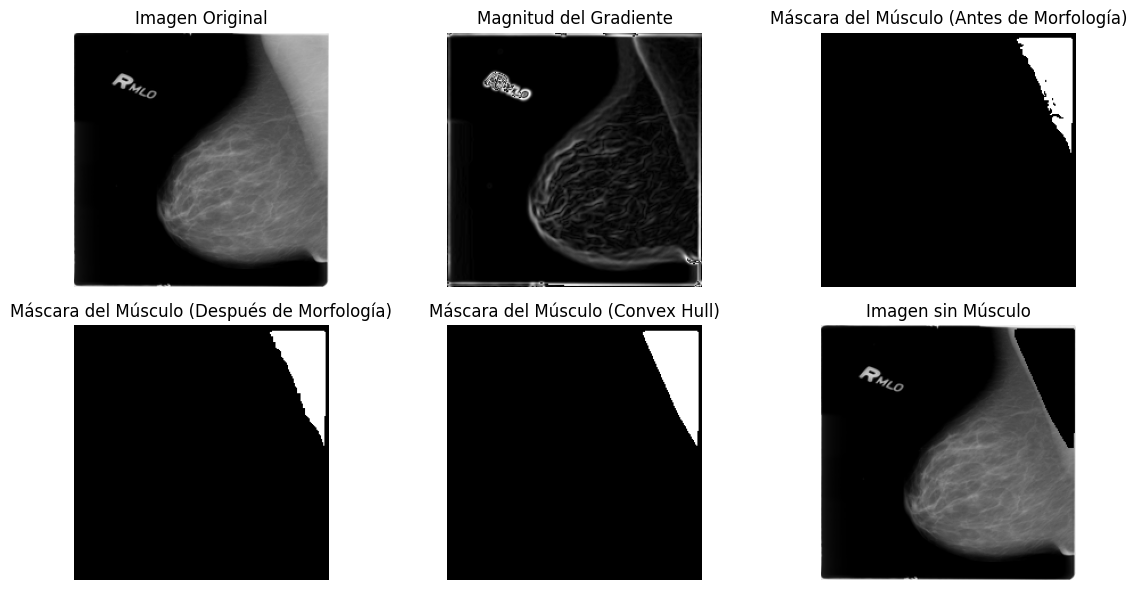

In [94]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.title('Imagen Original')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Magnitud del Gradiente')
plt.imshow(gradient_magnitude, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Máscara del Músculo (Antes de Morfología)')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Máscara del Músculo (Después de Morfología)')
plt.imshow(mask_morph, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Máscara del Músculo (Convex Hull)')
plt.imshow(mask_hull_f2, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Imagen sin Músculo')
plt.imshow(result, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()